In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
# import seaborn as sbs
from tqdm import tqdm_notebook as tqdm

# sbs.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Sine Wave Regression
在k-shot问题，每个任务都包含修改的正弦函数。每个任务可以定义为$y = asin(x+b)$,a和b是随机被选择的，
训练好的神经网络的是仅仅基于10个样本（x,y） 给出x去寻找y。

We start with a simple regression problem that illustrates the basic principles of MAML. Each task involves regressing from the input to the output of a sine wave, where the amplitude and phase of the sinusoid are varied between tasks. Thus, p(T ) is continuous, where the amplitude varies within [0.1, 5.0] and the phase varies within [0, π], and the input and output both have a dimensionality of 1. During training and testing, datapoints x are sampled uniformly from [ 5.0, 5.0].

我们从一个简单的回归问题开始，这个问题说明了MAML的基本原则。每个任务都涉及从输入到输出的正弦波的回归，其中正弦波的振幅和相位在不同的任务之间是不同的。因此，p(T)是连续的，振幅在[0.1,5.0]内变化，相位在[0，π]内变化，输入和输出的维数都为1。在训练和测试期间，从[5.0,5.0]中统一采样数据点x。

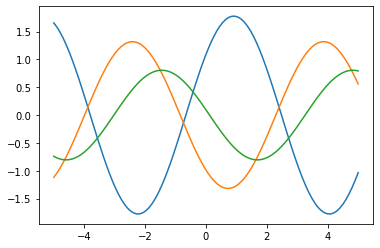

In [2]:
class  SineWaveTask:
    def __init__(self):
        self.a = np.random.uniform(0.1, 5)
        self.b = np.random.uniform(0, 2*np.pi)
        self.train_x = None
    def f(self, x):
        return self.a * np.sin(x + self.b)

    def training_set(self, size=10, force_new = False):
        if self.train_x == None and not force_new:
            self.train_x = np.random.uniform(-5, 5, size)
            x = self.train_x
        elif not force_new:
            x = self.train_x
        else:
            x = np.random.uniform(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)

    def test_set(self, size=50):
        x = np.linspace(-5, 5, size)
        y = self.f(x)
        return torch.Tensor(x), torch.Tensor(y)
    def plot(self, *args, **kwargs):
        x, y = self.test_set(size=100)
        return plt.plot(x.numpy(), y.numpy(), *args, **kwargs)

SineWaveTask().plot()
SineWaveTask().plot()
SineWaveTask().plot()
plt.show()

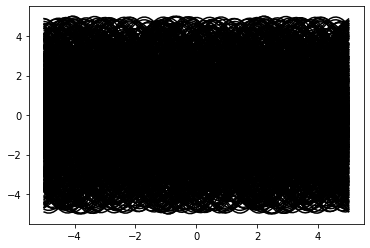

In [3]:
for _ in range(1000):
    SineWaveTask().plot(color='black')


由于跨多个任务的每个x都有多个可能的值,如果我们训练一个神经网络来处理多个任务同时,最好将只是返回平均为每个x y值在所有任务。



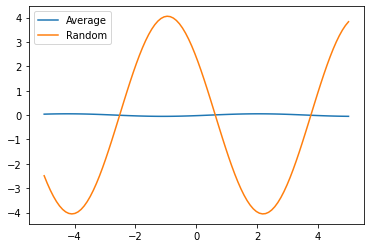

In [4]:
all_x , all_y = [],[]
for _ in range(10000):
    curx, cury = SineWaveTask().test_set(size=100)
    all_x.append(curx.numpy())
    all_y.append(cury.numpy())
avg, = plt.plot(all_x[0], np.mean(all_y, axis=0))
rand, = SineWaveTask().plot()
plt.legend([avg, rand], ['Average', 'Random'])
plt.show()

平均值基本上是0，这意味着训练有很多任务的神经网络到处都会返回0！



In [ ]:
TRAIN_SIZE = 10000
TEST_SIZE = 1000

class ModifiableModule(nn.Module):
    def params(self):
        return  [p for _, p in self.named_params()]


